# SHARK QUEST
## New Kids On The Block



In [80]:
%load_ext autoreload
%autoreload 2 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
# Import depedencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cleaning import *

In [82]:
# Settings
pd.set_option('display.max_rows', 80)
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_colwidth', 100)

In [83]:
# Load the data
shark_attacks_df = pd.read_excel('GSAF5.xls')
shark_attacks = shark_attacks_df.copy()

countries_df = pd.read_csv('country_coord.csv')
countries = countries_df.copy()

shark_attacks.head()

Date    Year        Type    Country              State  \
0  15 Mar 2024  2024.0  Unprovoked  AUSTRALIA         Queensland   
1  04 Mar 2024  2024.0  Unprovoked        USA             Hawaii   
2  02 Mar-2024  2024.0  Unprovoked        USA             Hawaii   
3  25 Feb-2024  2024.0  Unprovoked  AUSTRALIA  Western Australia   
4  14 Feb-2024  2024.0  Unprovoked      INDIA        Maharashtra   

                           Location  Activity                 Name Sex  Age  \
0                     Bargara Beach  Swimming       Brooklyn Sauer   F   13   
1                Old Man's, Waikiki   Surfing        Matthew White   M  NaN   
2                    Rainbows, Oahu  Swimming                  NaN   F   11   
3        Sandlnd Island, Jurian Bay       NaN               female   F   46   
4  Vaitarna River, Palghar District   Fishing  Vicky Suresh Govari   M   32   

                                     Injury Unnamed: 11   Time  \
0  Minor injuries to back, abdomen and legs         NaN  16h00   
1            No injury, shark bit surfboard           N    NaN   
2                  Lacerations to left foot           N  13h30   
3                                Leg bitten           N  11h30   
4            Calf of lower left leg injured           N    NaN   

         Species                      Source  pdf href formula href  \
0     Tiger shark      Yahoo News, 3/15/2024  NaN          NaN  NaN   
1  Tiger shark 8'          Surfer, 3/6/2024F  NaN          NaN  NaN   
2  3' to 4' shark  Hawaii News Now, 3/4/2024  NaN          NaN  NaN   
3     Tiger shark        WA Today, 2/26/2024  NaN          NaN  NaN   
4  Bull shark, 7'  Times of India, 2/14/2024  NaN          NaN  NaN   

  Case Number Case Number.1  original order Unnamed: 21 Unnamed: 22  
0         NaN           NaN             NaN         NaN         NaN  
1         NaN           NaN             NaN         NaN         NaN  
2         NaN           NaN             NaN         NaN         NaN  
3         NaN           NaN             NaN         NaN         NaN  
4         NaN           NaN             NaN         NaN         NaN

In [84]:
# Format all columns names
shark_attacks.columns = [col.strip().replace(" ", "_").replace(".", "").lower() for col in shark_attacks.columns]

In [85]:
# Contract
data_schema = dictionnary_from_json('schema')

In [86]:
# Creating new columns
shark_attacks['severity'] = shark_attacks_df['Injury']

In [87]:
# Selecting columns
shark_attacks = shark_attacks[[col for col in data_schema]]

In [88]:
# Strip strings
shark_attacks = shark_attacks.apply(lambda x: x.str.strip() if x.dtype == 'object' else x)

In [89]:
# Handling missing values
shark_attacks.replace(['N/A', 'null', '--'], np.nan, inplace=True)

In [90]:
# Remove duplicates
shark_attacks.drop_duplicates(keep=False, inplace=True)

In [91]:
# Reset Index
shark_attacks.reset_index(inplace=True)

In [92]:
# Reformat values
replacements = dictionnary_from_json('replacements')

for col, values in replacements.items():
    shark_attacks[col] = shark_attacks[col].apply(
        replace_string_patterns, replacements=values)
    
uncaught = shark_attacks['severity'][~shark_attacks['severity'].isin(['INJURY','FATALITY'])] 
uncaught

27                                                  No injury. No attack; the shark  simply head-butted him
31                                                 Dinghy damaged by shark. No injurty to the 5 men onboard
37                                                                                       Body not recovered
63                                                               No injury to occupants, shark defated boat
81                                                                                                         
95                                                                                 No injury, kayak damaged
102                                                                                                     NaN
109                                                                                   Death by misadventure
110                                                                                            Questionable
132                         

In [93]:
# Reformat country
shark_attacks['country'] = shark_attacks['country'].apply(lambda x: x.lower() if isinstance(x, str) else x)
replace_to_nan(shark_attacks["country"], ["england","scotland"], "united kingdom")
replace_to_nan(shark_attacks["country"], ["usa", "hawaii"], "united states")
replace_to_nan(shark_attacks["country"], ["reunion"], "france")
replace_to_nan(shark_attacks["country"], ["columbia"], "colombia")
replace_to_nan(shark_attacks["country"], ["new guinea"], "papua new guinea")


# unify country, converts all low value "country" ocorrences into <NA>. Also sets Country as string-type
country_list = [x.lower() for x in countries['Country']]
shark_attacks["country"] = shark_attacks["country"].where(shark_attacks["country"].isin(country_list), np.nan)

In [94]:
# Clean dates
shark_attacks['date'] = pd.to_datetime(shark_attacks['date'], errors='coerce') #Drops unsavable mess
shark_attacks['date'] = shark_attacks['date'].dt.strftime('%d-%m-%Y') 
shark_attacks['date'] = shark_attacks['date'].ffill() #Fills forward to avoid time gaps

In [95]:
# Cast correct types
columns_types = {key: value['dtype'] for key, value in data_schema.items()}
shark_attacks = shark_attacks.astype(columns_types)

In [96]:
# Clean categories
for column in shark_attacks.select_dtypes(include=['category']).columns:
    shark_attacks[column] = shark_attacks[column].astype('string')
    shark_attacks[column] = pd.Categorical(shark_attacks[column], categories=set(data_schema[column]['categories']), ordered=True)
    shark_attacks[column] = shark_attacks[column].where(shark_attacks[column].isin(data_schema[column]['categories']), other=data_schema[column]['categories'][-1])
    shark_attacks[column] = shark_attacks[column].astype('category')


In [97]:
# Add helper columns
shark_attacks['severity_score'] = shark_attacks['severity'].apply(lambda x: 3 if x == 'FATALITY' else 2 if x == 'INJURY' else 1)

In [98]:
# Clean copy for analysis
shark_attacks_clean = shark_attacks.copy()
shark_attacks_clean

index        type       date                   country  \
0         0  UNPROVOKED 2024-01-03                 australia   
1         1  UNPROVOKED 2024-01-03             united states   
2         2  UNPROVOKED 2024-01-03             united states   
3         3  UNPROVOKED 2024-01-02                 australia   
4         4  UNPROVOKED 2024-01-02                     india   
5         5    PROVOKED 2024-01-02                      <NA>   
6         6  UNPROVOKED 2024-01-01                 australia   
7         7  UNPROVOKED 2024-01-01                   bahamas   
8         8  UNPROVOKED 2024-01-01                 australia   
9         9    PROVOKED 2024-01-01              south africa   
10       10  UNPROVOKED 2023-01-12             united states   
11       11  UNPROVOKED 2023-01-12                    mexico   
12       12  UNPROVOKED 2023-01-12                 australia   
13       13  UNPROVOKED 2023-01-12                 australia   
14       14  UNPROVOKED 2023-01-12                 australia   
15       15  UNPROVOKED 2023-01-12               new zealand   
16       16     INVALID 2023-01-12                    mexico   
17       17     INVALID 2023-01-12                    mexico   
18       18  UNPROVOKED 2023-01-12                 australia   
19       19  UNPROVOKED 2023-01-12                   bahamas   
20       20  UNPROVOKED 2023-01-12                    mexico   
21       21  UNPROVOKED 2023-01-11                 australia   
22       22  UNPROVOKED 2023-01-11                   bahamas   
23       23  UNPROVOKED 2023-01-11                 australia   
24       24  UNPROVOKED 2023-01-11             united states   
25       25  UNPROVOKED 2023-01-11                 australia   
26       26  UNPROVOKED 2023-01-11               new zealand   
27       27     INVALID 2023-01-11                     egypt   
28       28  UNPROVOKED 2023-01-10                 australia   
29       29  UNPROVOKED 2023-01-10             united states   
30       30    PROVOKED 2023-01-10                    mexico   
31       31  WATERCRAFT 2023-01-10                 australia   
32       32  UNPROVOKED 2023-01-10                    belize   
33       33  UNPROVOKED 2023-01-10             united states   
34       34  UNPROVOKED 2023-01-10             united states   
35       35  UNPROVOKED 2023-01-10             united states   
36       36  UNPROVOKED 2023-01-10                 australia   
37       37  UNPROVOKED 2023-01-10             united states   
38       38  UNPROVOKED 2023-01-09             united states   
39       39  UNPROVOKED 2023-01-09                     egypt   
40       40     INVALID 2023-01-09             united states   
41       41  UNPROVOKED 2023-01-09             united states   
42       42  UNPROVOKED 2023-01-09               philippines   
43       43  WATERCRAFT 2023-01-09                      <NA>   
44       44  UNPROVOKED 2023-01-09             united states   
45       45  UNPROVOKED 2023-01-09             united states   
46       46  UNPROVOKED 2023-01-08                 australia   
47       47  UNPROVOKED 2023-01-08             united states   
48       48  WATERCRAFT 2023-01-08             united states   
49       49     INVALID 2023-01-08                   bahamas   
50       50  UNPROVOKED 2023-01-08                     spain   
51       51    PROVOKED 2023-01-08                  portugal   
52       52  UNPROVOKED 2023-01-08                     samoa   
53       53  UNPROVOKED 2023-01-08             united states   
54       54  UNPROVOKED 2023-01-07             united states   
55       55  UNPROVOKED 2023-01-07             united states   
56       56  UNPROVOKED 2023-01-07             united states   
57       57  UNPROVOKED 2023-01-07                 australia   
58       58  UNPROVOKED 2023-01-07                 australia   
59       59  UNPROVOKED 2023-01-07             united states   
60       60  UNPROVOKED 2023-01-07                  colombia   
61       61  UNPROVOKED 2023-01-07    

# ANALYSIS

/var/folders/7w/s5bmwwgs2176bk3y33c2nv2m0000gn/T/ipykernel_75734/3300347951.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Time Category', y='Number of Attacks', data=df_time, palette='Blues')


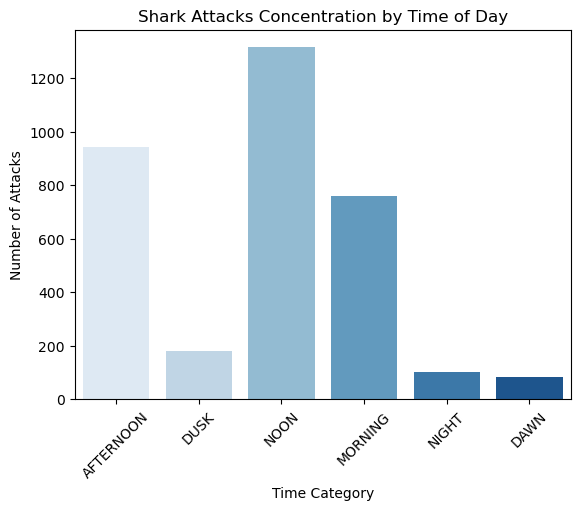

In [99]:
#Hypothesis: Shark attacks are more concentrated in the PM 
time_stats = shark_attacks['time'].cat.remove_categories('UNKNOWN')

time_counts = time_stats.value_counts()
time_counts


df_time = pd.DataFrame(
    {'Time Category': time_counts.index,
     'Number of Attacks': time_counts.values  
    }
)
df_time
import seaborn as sns
import matplotlib.pyplot as plt
sns.barplot(x='Time Category', y='Number of Attacks', data=df_time, palette='Blues')
plt.title('Shark Attacks Concentration by Time of Day')
plt.xlabel('Time Category')
plt.ylabel('Number of Attacks')
plt.xticks(rotation=45)
plt.show()

#Conclusion: we could easily determine that shark attacks are most concentrated during NOON based on the dataset.

# PLAN

In [100]:
# Source, PDF, Case Number as possible duplicate finder or year / date fill

# Henning : Date, Type
# Ricardo : Country, State
# Linh : Location, Activity
# Jp : Injury, Time

# Type : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Provoked, Unprovoked, Invalid
# Date : datetime : Clean "Reported" - Harmonize Format - Cast weird into NaT. Final => Dates (as datetime), NaT
# Country : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# State : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Location : string : Strip spaces - Formatting - Replace weird characters - cast weird values as NaN => Strings, Nan
# Activity : category : Merge some columns based on categories. Trim labels. Nan into invalid. Final => Few categories to be determined
# Injury : category : Merge columns based on keywords. Nan into other. Final => Fatality, Injury, Other
# Time : category : Cast into categories Final => morning (6-10) noon (10-14) afternoon( 14-18) dusk (18-22) night (22 - 2) dawn (2-6) maybe as integers (0-5)

# Todo
# Remove obvious duplicate (entire line) - Ricardo
# Remove fuzzy duplicates (case number? dates?) - Ricardo

# Functions :
# Merge categories : (*categories to be merged, target) - Henning
# Strip function : strips spaces - Linh
# Replace as Nan, Nat, ... function - Ricardo
# DONE - Replace by keyword function - Jp
# DONE - Cast to dateTime function
# Matching function (find similarities, keyword based?)
# DONE - Reformat dates, strings
# Filter function

## Selecting
- Select relevant columns
- Analyse relevant columns

## Cleaning :
- Cast to appropriate data types
    - General cleaning
        - identify duplicates
            - fuzzy
        - removing duplicates
            - remove
            - merge
        - handling null values
            - remove
            - replace
        - manipulating strings
        - formatting the data.

- Wrong inputs
- Outliers

### GENERAL CLEANING
1. Rename columns
2. Drop columns
3. Remove duplicates
    - Remove full dupes
    - Remove fuzzy search
4. Strip values
5. Reset Index

### SPECIFIC CLEANING
1. Search / Replace / Reformat strings
2. Merge categories
3. Cast to Null
4. Cast correct type
5. Create new columns


## Hypothesis

### TIME
- Shark attacks are seasonal (Summer)
- Shark attacks are increasing 
- Shark attacks are more concentrated in the PM 

### LOCATION
- Some countries are more attack prone (Australia)
- Some countries are more likely to be fatal (Australia)


### DEMOGRAPHICS
- Males are more likely to get attacked
- Males are more likely to get provoke a shark
- Provoked attacked are more fatal
- Young persons are more likely to get attacked
- Old persons are more likely to get killed

- Names more likely to get attacked (John)

### OTHER
- Some species are more aggressive (Tiger Shark)
- Some activities are more likely (Surfing)
- Some activities are more fatal

- Full moon? 😂


Retained :
- Shark Species have a gender preference (score) => JP => Heinning
- Some countries are more provocative against sharks* => Ricardo
- Shark attacks are more concentrated in the PM => Linh

- Names more likely to get attacked (John) => JP?

## Business Ideas

- App that gives a likelyhood of attack based on location and time
- Vacations far away from sharks for phobics
- Witness attacks for masochists

- Surf school at the safest places / seasons
- Fishing supplies => shark repellant by activities
- Safety training to avoid provocations / live in harmony

- Shark repellant => best spots
- Insurance for surfers, premiums for high risk areas